In [10]:
from pydantic import BaseModel, Field
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_groq import ChatGroq
from langchain.agents import tool
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage ,SystemMessage

from typing import Optional, List

In [ ]:
llm = ChatGroq(
    model="deepseek-r1-distill-llama-70b",
    groq_api_key="your_api_key_here"
)

In [12]:
from pydantic import BaseModel
from langchain_core.messages import SystemMessage

template = """Your job is to get information from a user about what type of prompt template they want to create.

You should get the following information from them:

- What the objective of the prompt is
- What variables will be passed into the prompt template
- Any constraints for what the output should NOT do
- Any requirements that the output MUST adhere to

If you are not able to discern this info, ask them to clarify! Do not attempt to wildly guess.

After you are able to discern all the information, call the relevant tool.
"""

class PromptTemplateInfo(BaseModel):
    """Instructions on how to prompt the LLM."""
    objective: str
    variables: list[str]
    constraints: list[str]
    requirements: list[str]

llm_with_tools = llm.bind_tools([PromptTemplateInfo])

def info_chain(state):
    response = llm_with_tools.invoke(
        state["messages"] + [SystemMessage(content=template)]
    )
    return {"messages": [response]}

In [ ]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage ,SystemMessage

prompt_system = """Based on the following requirements, write a good prompt template:

{reqs}"""
def get_prompt_messages(messages: list):
    """
    Generates a list of messages for the prompt after processing tool calls.

    Args:
        messages (list): A list of messages (AIMessage, HumanMessage, ToolMessage).

    Returns:
        list: A list of messages starting with a SystemMessage containing
              the tool call arguments formatted into the system prompt,
              followed by any messages that came after the tool call.
    """
    tool_call = None 
    other_msgs = []   
    for m in messages:
        if isinstance(m, AIMessage) and m.tool_calls:
            tool_call = m.tool_calls[0]["args"]
        elif isinstance(m, ToolMessage):
            continue
        elif tool_call is not None:
            other_msgs.append(m)
    return [SystemMessage(content=prompt_system.format(reqs=tool_call))] + other_msgs

def prompt_chain(state):
    messaages = get_prompt_messages(state["messages"])
    response=llm.invoke(messaages)
    return {"messages": response}

In [14]:
from typing import Literal
from langgraph.graph import END
def get_state(state):
    messages = state["messages"]
    if isinstance(messages[-1], AIMessage) and messages[-1].tool_calls:
        return "prompt"
    elif not isinstance(messages[-1], HumanMessage):
        return END
    return "info"

In [15]:
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from typing import Annotated, TypedDict, List
import uuid
class State(TypedDict):
    messages: Annotated[List, add_messages]

memory = InMemorySaver()

workflow = StateGraph(State)

workflow.add_node("info", info_chain)
workflow.add_node("prompt", prompt_chain)

workflow.add_edge(START, "info")
workflow.add_edge("prompt", END) 

workflow.add_conditional_edges("info", get_state, ["info", "prompt", END])

graph = workflow.compile(checkpointer=memory)
config = {"configurable": {"thread_id": str(uuid.uuid4())}}


In [16]:
events=graph.stream(
        {"messages": [HumanMessage(content="Write a prompt template for a health chatbot")]}, config=config
    )


In [17]:
for event in events:
    print(event)

{'info': {'messages': [AIMessage(content='', additional_kwargs={'reasoning_content': "Okay, the user wants to create a prompt template for a health chatbot. I need to figure out the necessary details to call the PromptTemplateInfo function.\n\nFirst, I should ask about the objective. What's the main goal? Maybe it's to help users with general health inquiries.\n\nNext, variables. What info will be passed in? Perhaps symptoms, user age, medical history.\n\nConstraints: The chatbot shouldn't diagnose diseases or recommend meds without a doctor.\n\nRequirements: Responses must be supportive, accurate, and suggest seeing a professional if needed.\n\nI think that covers everything. Now, I can call the function with these details.\n", 'tool_calls': [{'id': 'n1ynzqdcb', 'function': {'arguments': '{"constraints":["Do not diagnose diseases","Do not recommend medications without consulting a doctor"],"objective":"To provide helpful and accurate responses to user health inquiries","requirements":

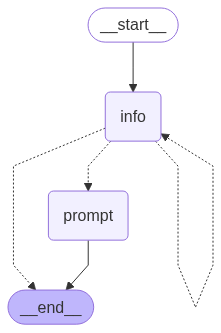

In [18]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))